In [1]:
# Basic NGSolve things
from netgen.geom2d import SplineGeometry
from ngsolve import *

# ngsxfem and the mlset convenience layer 
from xfem import *
from xfem.mlset import *

import matplotlib.pyplot as plt
import numpy as np

import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# reference data from MFD
ref1 = np.loadtxt('data/mfd_geiger_conductive_x_eq_0.5.csv',comments='#',delimiter=',',skiprows=1)
ref2 = np.loadtxt('data/mfd_geiger_conductive_y_eq_0.7.csv',comments='#',delimiter=',',skiprows=1)
ref3 = np.loadtxt('data/mfd_geiger_blocking_0_0.1_to_0.9_1.csv',comments='#',delimiter=',',skiprows=1)

In [2]:
# Complex
from read_gmsh import ReadGmsh
mesh = ReadGmsh("mesh/geiger.msh")
from ngsolve import Mesh
mesh = Mesh(mesh)

eps = 1e-6
for e in mesh.Elements(BND):
    p0 = mesh[e.vertices[0]].point
    p1 = mesh[e.vertices[1]].point
    if abs(p0[0]-0)<eps and abs(p1[0]-0)< eps:
        mesh.ngmesh.SetBCName(e.index, "left")
    elif abs(p0[0]-1)<eps and abs(p1[0]-1)< eps:
        mesh.ngmesh.SetBCName(e.index, "right")
    elif abs(p0[1]-1)<eps and abs(p1[1]-1)< eps:
        mesh.ngmesh.SetBCName(e.index, "top")
    elif abs(p0[1]-0)<eps and abs(p1[1]-0)< eps:
        mesh.ngmesh.SetBCName(e.index, "bottom")
    else:
        mesh.ngmesh.SetBCName(e.index, "frac")

gfu = GridFunction(H1(mesh))
gfu.Set(1,definedon=mesh.Boundaries("frac"))
Draw(gfu, mesh)

V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac")))
print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

matrix elements:  1348 ; fracture elements:  91


### 1) Fracture

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  7703  Global:  2311 V:  4044 W:  1348 M:  2041 Vf:  182 Mf:  88


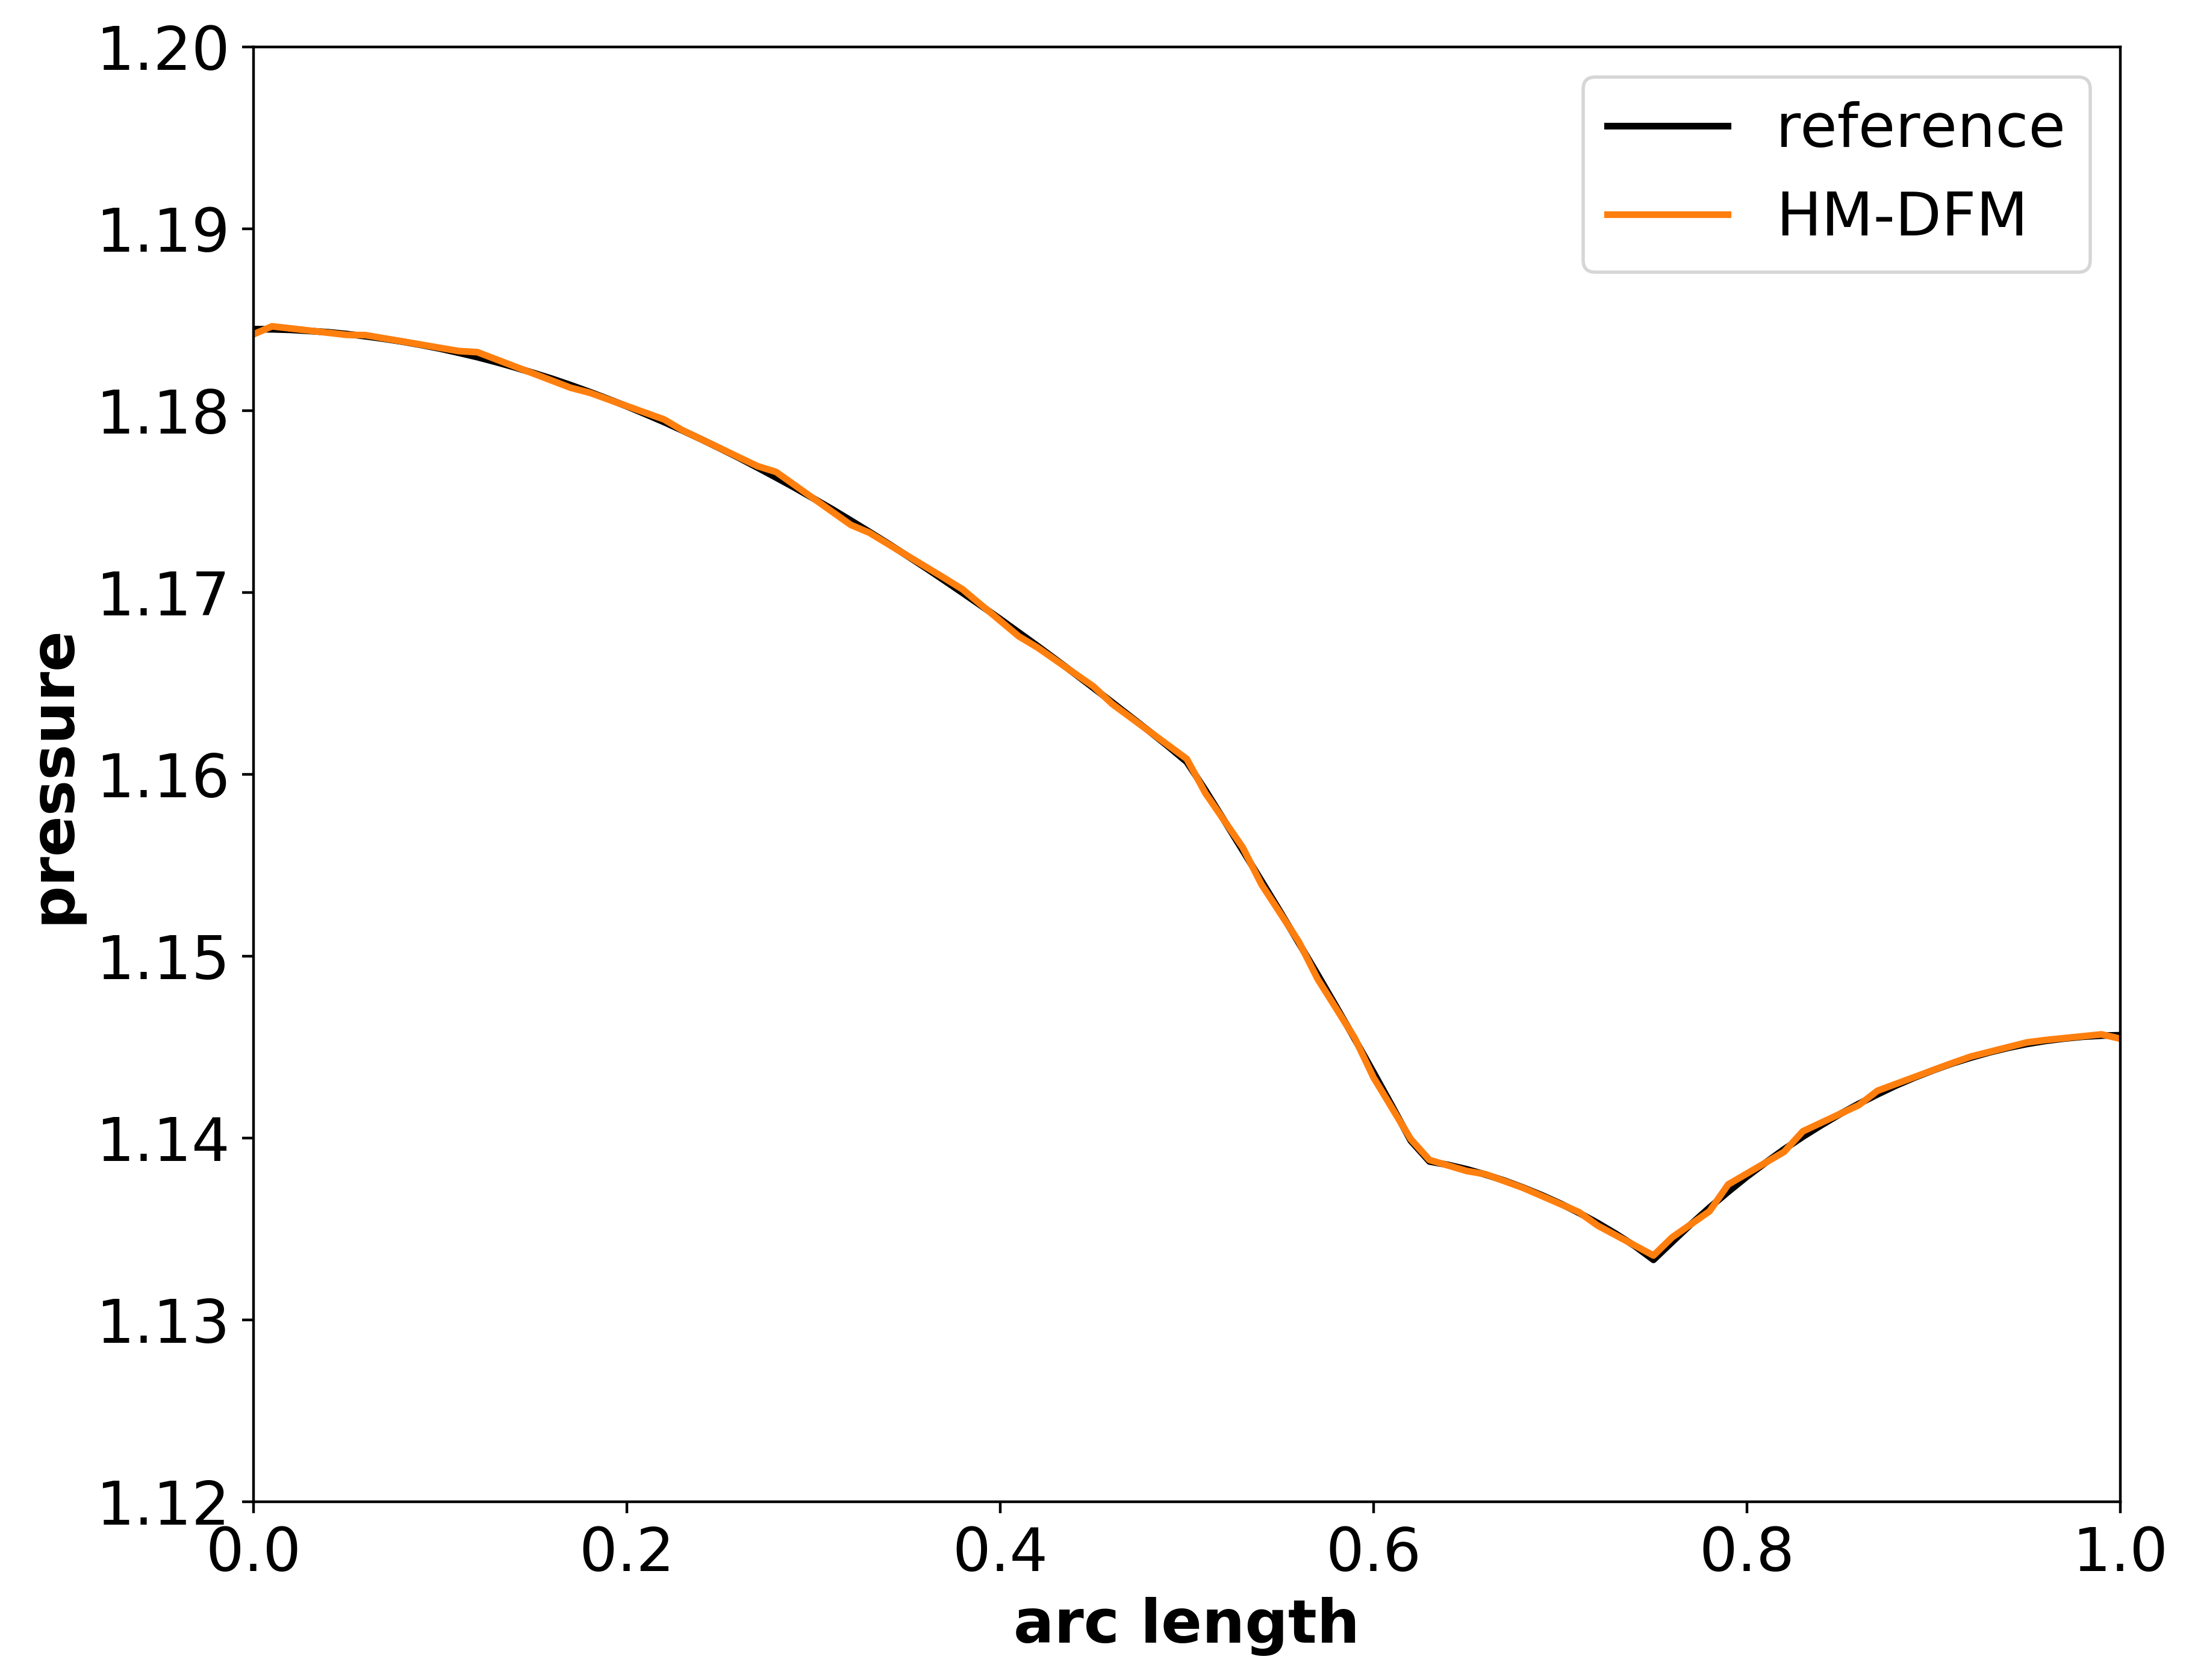

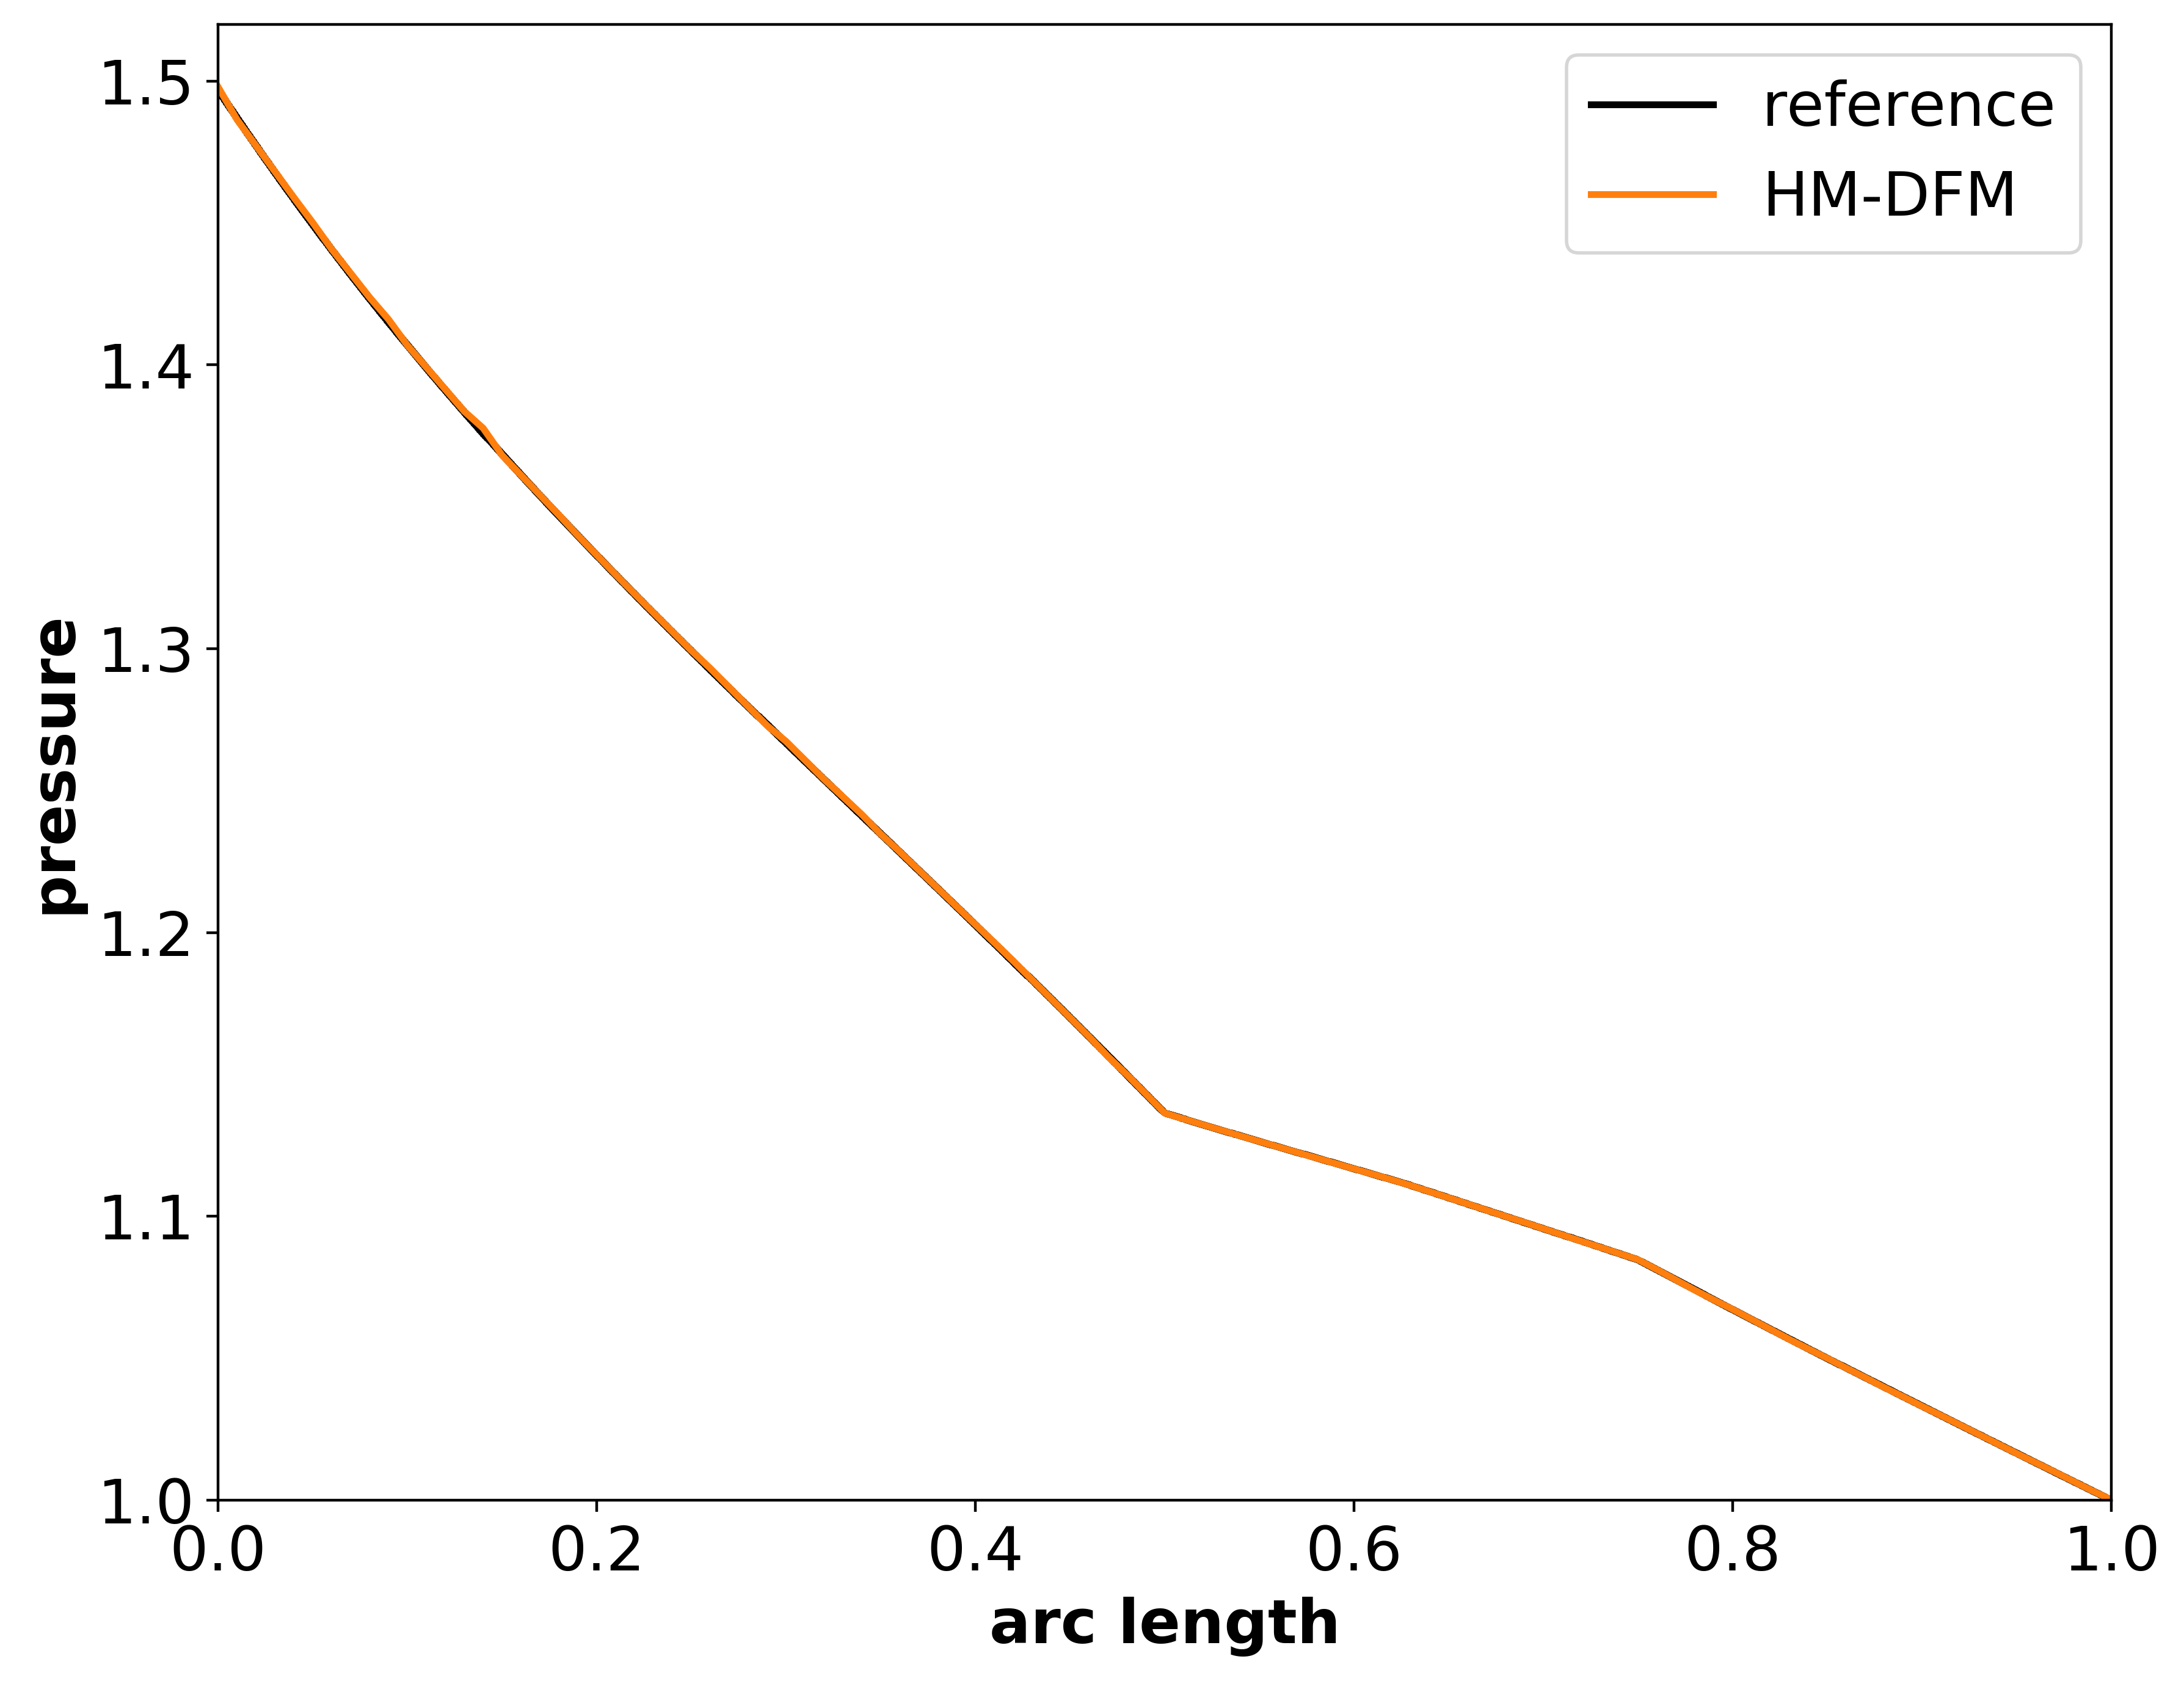

In [3]:
# each fracture is represented by a mlset with 2 level set functions (line+circle)
nfs = 6
level_sets_p1 = tuple(tuple(GridFunction(H1(mesh, order=1)) for i in range(2)) for j in range(nfs))
frac0 = np.array([[1, 0, 0.5, 1, 0.5], 
                  [2, 0.5, 0.75, 1, 0.75],
                  [3, 0.5, 0.625, 0.75, 0.625],
                  [4, 0.5, 0, 0.5, 1],
                  [5, 0.75, 0.5, 0.75, 1],
                  [6, 0.625, 0.5, 0.625, 0.75]
                 ])
# interface indicator/interface elements/tangential directions
lset_ifs = [None for j in range(nfs)]
lset_elems = [None for j in range(nfs)]
ts = [None for j in range(nfs)]
ns = [None for j in range(nfs)]

# all fractures
for i, lset_p1 in enumerate(level_sets_p1):
    x0, y0, x1, y1 = frac0[i][1], frac0[i][2],frac0[i][3],frac0[i][4]
    if x0==x1:
        l1 = x-x0
    elif y0==y1:
        l1 = y-y0
    else:
        l1 = (x-x0)/(x1-x0)-(y-y0)/(y1-y0)
    len1 = sqrt((x1-x0)**2+(y1-y0)**2)
    xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
    r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
    InterpolateToP1(l1, lset_p1[0]) # line segment
    InterpolateToP1(r1, lset_p1[1]) # circ
    mlci = MultiLevelsetCutInfo(mesh, lset_p1)
    frac = DomainTypeArray((IF, NEG))
    lset_ifs[i] = {"levelset": lset_p1, "domain_type": frac, "subdivlvl" : 0}
    lset_elems[i] = mlci.GetElementsWithContribution(frac)
    
    n1 = 1.0/grad(lset_p1[0]).Norm() * grad(lset_p1[0])
    ts[i] = CoefficientFunction((-n1[1], n1[0]))
    ns[i] = n1
    if i ==0:
        bitarray = BitArrayCF(lset_elems[i])
    else:
        bitarray += BitArrayCF(lset_elems[i])

# draw the interface elements for the fracture
# Draw(bitarray, mesh, max=1)

# hybrid-mixed solver: GOOD
order = 0
frac = "frac"
V = HDiv(mesh, order=order, RT=True, discontinuous=True)
W = L2(mesh, order=order)
M = FacetFESpace(mesh, order=order, dirichlet="right")
Vf = Compress(SurfaceL2(mesh, order=order+1, definedon=mesh.Boundaries(frac)))
Mf = Compress(H1(mesh, order=1, definedon=mesh.Boundaries(frac)))

fes = V*W*M*Vf*Mf
(u, p, phat, uf, pbar), (v, q, qhat, vf, qbar) = fes.TnT()

# hackers
gfL = GridFunction(H1(mesh))
gfR = GridFunction(H1(mesh))
gfL.Set(1, definedon=mesh.Boundaries("left"))
gfR.Set(1, definedon=mesh.Boundaries("right"))

eps = 1e-4
K0, K1, K2 = 1, 1e4, 1e-4

condense=True
a = BilinearForm(fes, condense=condense)
h = specialcf.mesh_size
n = specialcf.normal(2)
t = specialcf.tangential(2)
# subdomain 1
a += (-1/K0*u*v+p*div(v)+q*div(u))*dx
a += (-1/eps/K1*uf.Trace()*vf.Trace()+phat.Trace()*grad(vf).Trace()*t+qhat.Trace()*grad(uf).Trace()*t
     )*ds("frac")
a += (-v*n*phat-u*n*qhat)*dx(element_boundary=True)
gfn = GridFunction(Compress(SurfaceL2(mesh, order=1, definedon=mesh.Boundaries(frac))))
count = 0
for e in mesh.Elements(BND):
    if e.mat=="frac":
        if e.vertices[0].nr > e.vertices[1].nr:
            gfn.vec[2*count+1] = -1
        else:
            gfn.vec[2*count+1] = 1 
        count += 1    
a += -(pbar*vf*gfn+uf*qbar*gfn)*ds(element_boundary=True, definedon="frac")
# dirichlet bc hack for Right
a += 1e8*gfR*(pbar*qbar)*ds(element_boundary=True, definedon="frac")


########### TODO

f = LinearForm(fes)
f += 1e8*(gfR)*qbar*ds(element_boundary=True, definedon="frac")
# f += gfL*gfn*qbar*ds(element_boundary=True, definedon="frac")
f += (qhat.Trace())*ds(definedon="left")

gfu = GridFunction(fes)

a.Assemble()
f.Assemble()

# top dirichlet data
gfu.components[2].Set(1, definedon=mesh.Boundaries("right"))

f.vec.data -= a.mat*gfu.vec
if condense==True:
    f.vec.data += a.harmonic_extension_trans * f.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
if condense==True:
    gfu.vec.data += a.harmonic_extension * gfu.vec 
    gfu.vec.data += a.inner_solve * f.vec

# Local postprocessing
V2 = L2(mesh, order=1, all_dofs_together=False)
ph = GridFunction(V2)

a2 = BilinearForm(V2)
f2 = LinearForm(V2)

p2, q2 = V2.TnT()
a2 += grad(p2)*grad(q2)*dx
a2.Assemble()
f2 += -1/K0*gfu.components[0]*grad(q2)*dx
f2.Assemble()

V2.FreeDofs()[:mesh.ne]=False
ph.vec[:mesh.ne].data=gfu.components[1].vec
ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec

# Draw(gfu.components[0], mesh, "vel")
Draw(ph, mesh, "soln")
# save data to vtk format for better visualization
vtkout = VTKOutput(ma=mesh, coefs=[ph], names=["pres"], filename="data/geigerA")
vtkout.Do()


plt.figure(figsize=(10,8), dpi=400)
xx = np.linspace(0, 1, 101)
pre = np.array([ph(mesh(0.5,xx0)) for xx0 in xx])
plt.plot(ref1.T[5], ref1.T[0], "k", linewidth=2)
plt.plot(xx,pre, "C1", linewidth=2)
plt.legend(["reference", "HM-DFM"])
plt.axis([0,1, 1.12,1.2])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig('data/geiger1.pdf', dpi=400)

plt.figure(figsize=(10,8), dpi=400)
pre = np.array([ph(mesh(xx0, 0.7)) for xx0 in xx])
plt.plot(ref2.T[5], ref2.T[0], "k", linewidth=2)
plt.plot(xx,pre, "C1", linewidth=2)
plt.legend(["reference", "HM-DFM"])
plt.axis([0,1, 1,1.52])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig('data/geiger2.pdf', dpi=400)

print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
     "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), "M: ", sum(M.FreeDofs()), 
     "Vf: ", sum(Vf.FreeDofs(True)), "Mf: ", sum(Mf.FreeDofs(True)))


### 2) Barrier: hybrid-mixed (non-conforming or conforming mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  7433  Global:  2041 V:  4044 W:  1348 M:  2041 Vf:  182 Mf:  88 ne:  1348
1442


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  7956  Global:  2188 V:  4326 W:  1442 M:  2188 Vf:  0 Mf:  0 ne:  1442


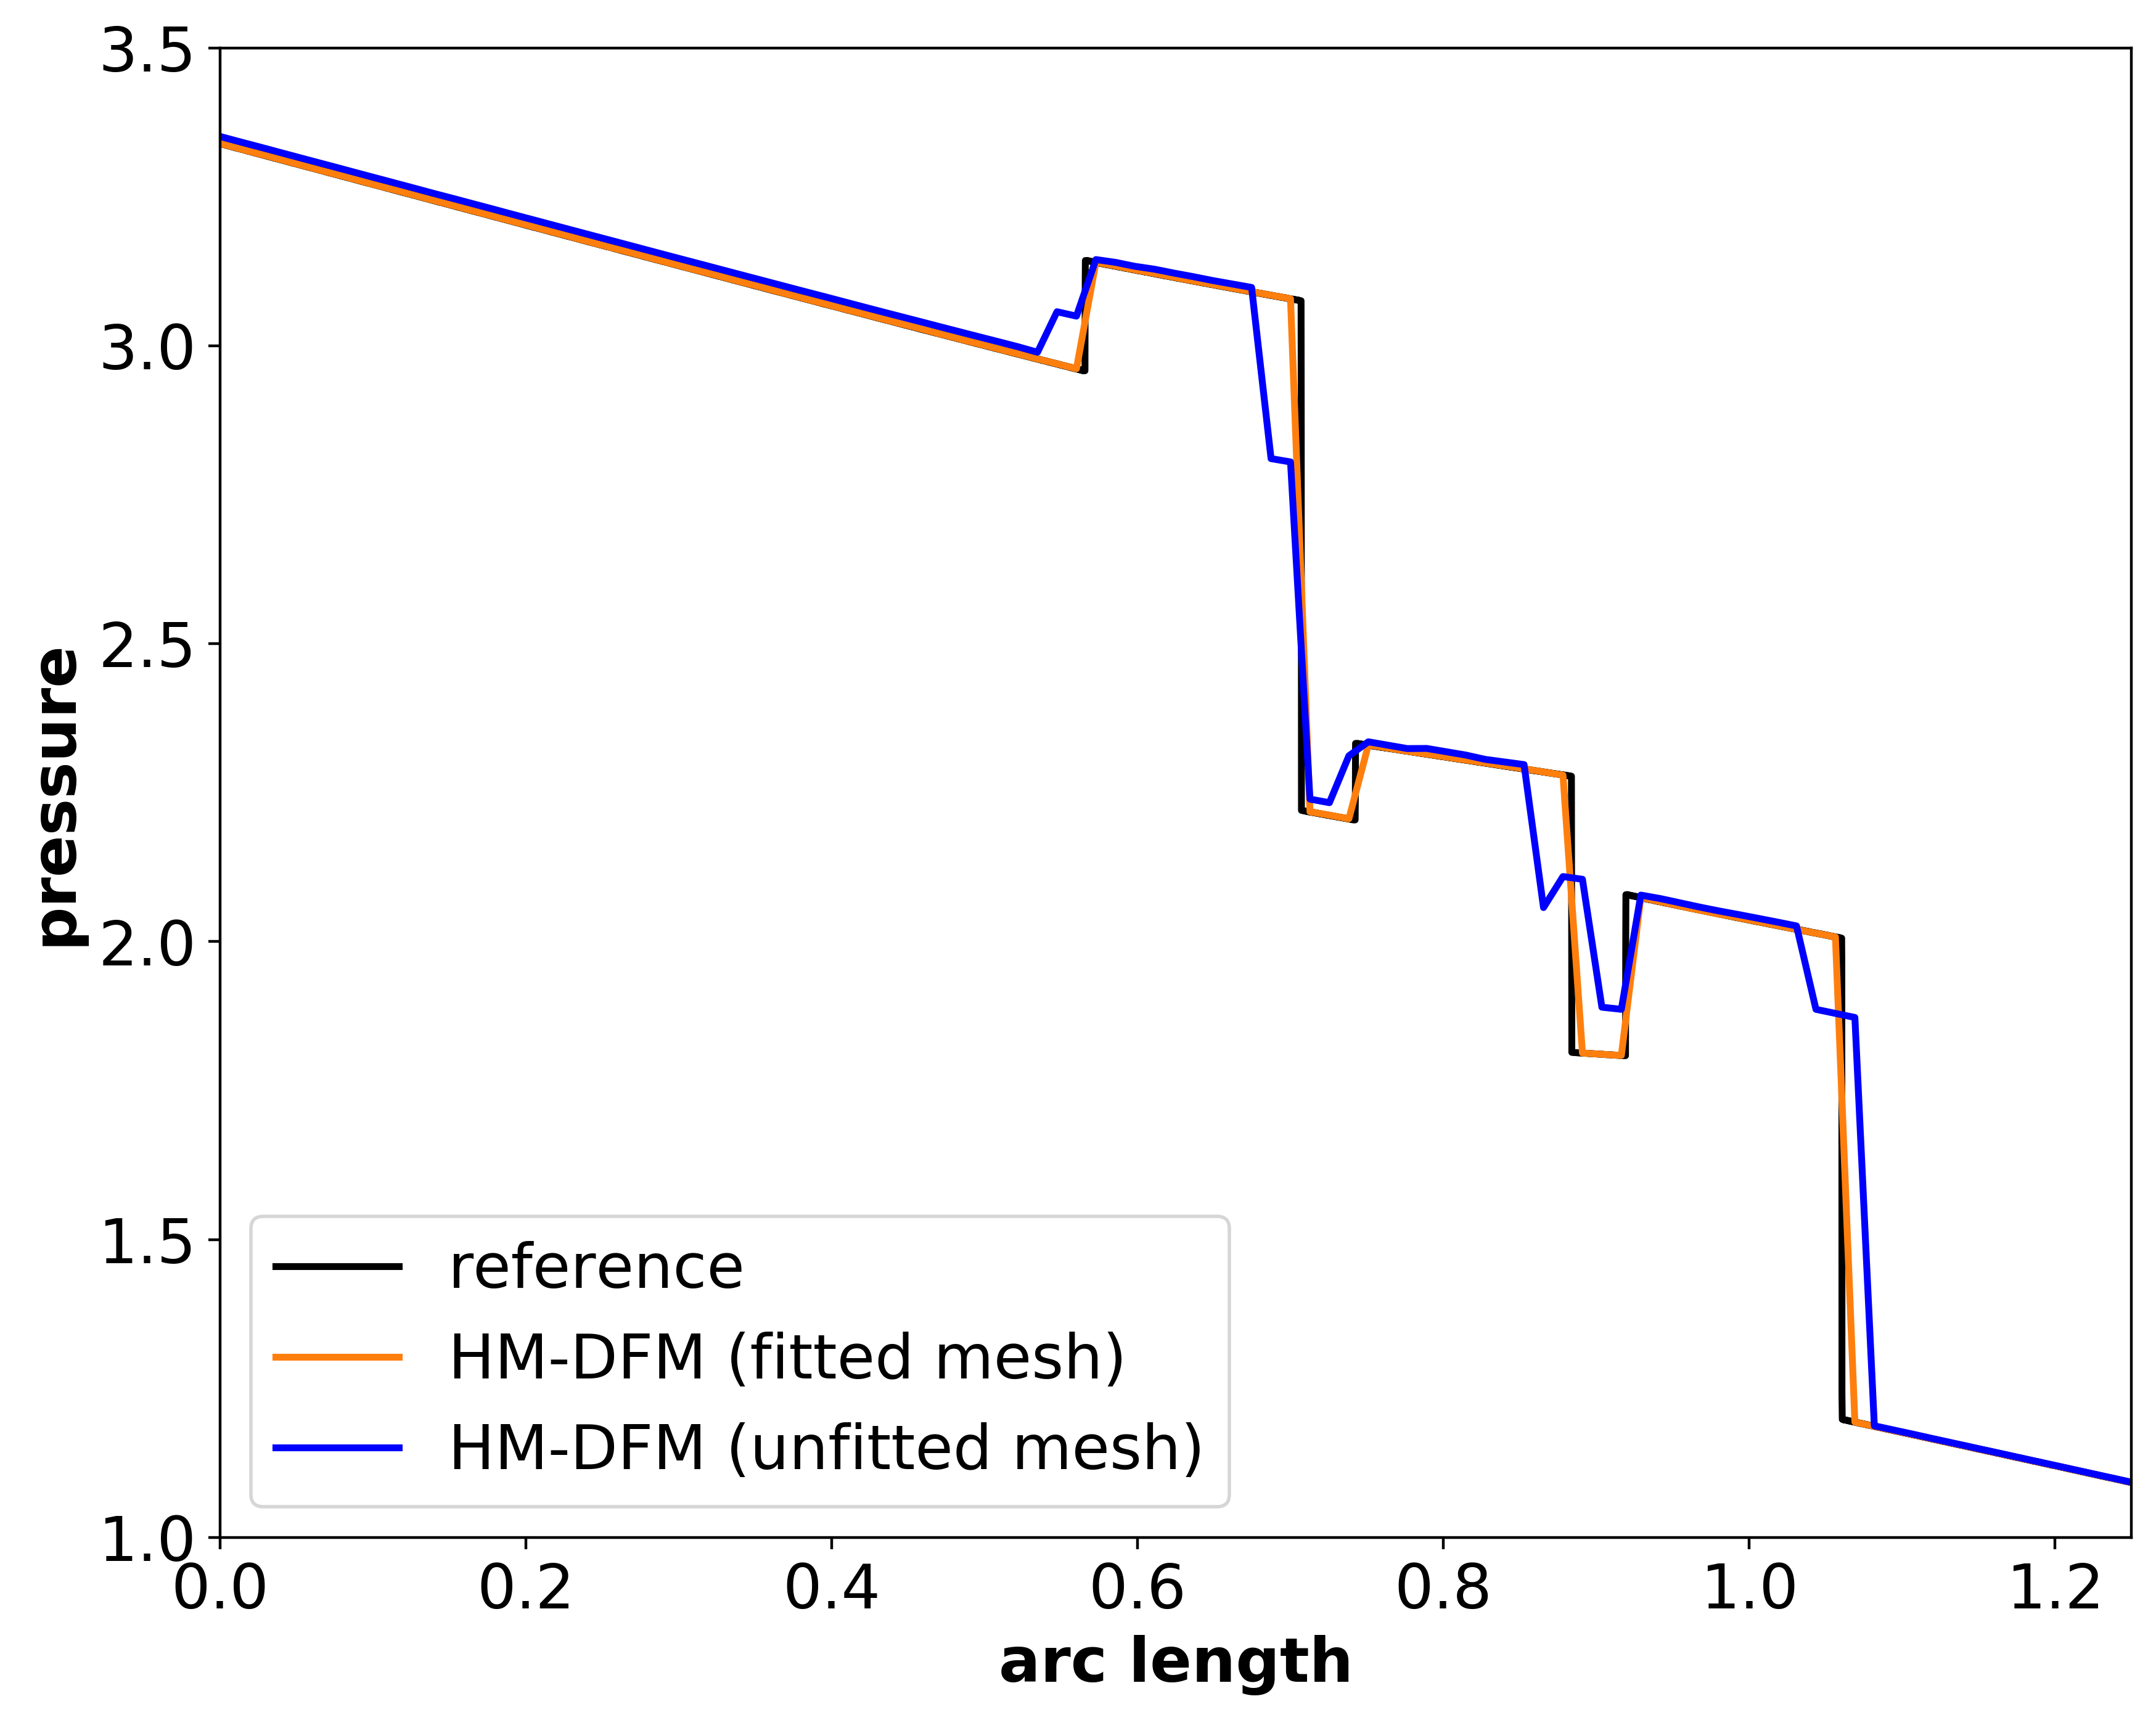

In [4]:
# Blocking: hybrid-mixed (Worked!!!)
xx = np.linspace(0, 0.9, 101)
pre = []

for m in range(2):
    if m==1: # use nonconforming mesh
        # non-conforming mesh
        geo = SplineGeometry()
        geo.AddRectangle((0, 0), (1, 1), 
                         bcs=("bottom", "right", "top", "left"), 
                        leftdomain=1, rightdomain=0)
        mesh = Mesh(geo.GenerateMesh(maxh=0.04))
        print(mesh.ne)

    # each fracture is represented by a mlset with 2 level set functions (line+circle)
    nfs = 6
    level_sets_p1 = tuple(tuple(GridFunction(H1(mesh, order=1)) for i in range(2)) for j in range(nfs))
    eps0 = 0
    frac0 = np.array([[1, 0, 0.5-eps0, 1, 0.5-eps0], 
                      [2, 0.5, 0.75-eps0, 1, 0.75-eps0],
                      [3, 0.5, 0.625-eps0, 0.75, 0.625-eps0],
                      [4, 0.5-eps0, 0, 0.5-eps0, 1],
                      [5, 0.75-eps0, 0.5, 0.75-eps0, 1],
                      [6, 0.625-eps0, 0.5, 0.625-eps0, 0.75]
                     ])
    # interface indicator/interface elements/tangential directions
    lset_ifs = [None for j in range(nfs)]
    lset_elems = [None for j in range(nfs)]
    ts = [None for j in range(nfs)]
    ns = [None for j in range(nfs)]

    # all fractures
    for i, lset_p1 in enumerate(level_sets_p1):
        x0, y0, x1, y1 = frac0[i][1], frac0[i][2],frac0[i][3],frac0[i][4]
        if x0==x1:
            l1 = x-x0
        elif y0==y1:
            l1 = y-y0
        else:
            l1 = (x-x0)/(x1-x0)-(y-y0)/(y1-y0)
        len1 = sqrt((x1-x0)**2+(y1-y0)**2)
        xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
        r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
        InterpolateToP1(l1, lset_p1[0]) # line segment
        InterpolateToP1(r1, lset_p1[1]) # circ
        mlci = MultiLevelsetCutInfo(mesh, lset_p1)
        frac = DomainTypeArray((IF, NEG))
        lset_ifs[i] = {"levelset": lset_p1, "domain_type": frac, "subdivlvl" : 0}
        lset_elems[i] = mlci.GetElementsWithContribution(frac)

        n1 = 1.0/grad(lset_p1[0]).Norm() * grad(lset_p1[0])
        ts[i] = CoefficientFunction((-n1[1], n1[0]))
        ns[i] = n1
        if i ==0:
            bitarray = BitArrayCF(lset_elems[i])
        else:
            bitarray += BitArrayCF(lset_elems[i])

    # hybrid-mixed solver: GOOD
    order = 0
    frac = "frac"
    V = HDiv(mesh, order=order, RT=True, discontinuous=True)
    W = L2(mesh, order=order)
    M = FacetFESpace(mesh, order=order, dirichlet="right")
    Vf = Compress(SurfaceL2(mesh, order=order+1, definedon=mesh.Boundaries(frac)))
    Mf = Compress(H1(mesh, order=1, definedon=mesh.Boundaries(frac)))

    fes = V*W*M
    (u, p, phat), (v, q, qhat) = fes.TnT()

    eps = 1e-4
    K0, K1, K2 = 1, 1e4, 1e-4

    condense=True
    a = BilinearForm(fes, condense=condense)
    h = specialcf.mesh_size
    n = specialcf.normal(2)
    t = specialcf.tangential(2)
    # subdomain 1
    a += (1/K0*u*v-p*div(v)-q*div(u))*dx
    for i in range(nfs):
        a += SymbolicBFI(levelset_domain = lset_ifs[i], 
                     form = eps/K2 * u*ns[i] * v*ns[i],
                    definedonelements=lset_elems[i])
    a += (phat*v*n+qhat*u*n)*dx(element_boundary=True)

    ########### TODO

    f = LinearForm(fes)
    f += -qhat.Trace()*ds("left")

    gfu = GridFunction(fes)

    a.Assemble()
    f.Assemble()

    # top dirichlet data
    gfu.components[2].Set(1, definedon=mesh.Boundaries("right"))

    f.vec.data -= a.mat*gfu.vec
    if condense==True:
        f.vec.data += a.harmonic_extension_trans * f.vec
    gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
    if condense==True:
        gfu.vec.data += a.harmonic_extension * gfu.vec 
        gfu.vec.data += a.inner_solve * f.vec

    # Local postprocessing
    V2 = L2(mesh, order=1, all_dofs_together=False)
    ph = GridFunction(V2)

    a2 = BilinearForm(V2)
    f2 = LinearForm(V2)

    p2, q2 = V2.TnT()
    a2 += grad(p2)*grad(q2)*dx
    a2.Assemble()
    f2 += -1/K0*gfu.components[0]*grad(q2)*dx
    f2.Assemble()

    V2.FreeDofs()[:mesh.ne]=False
    ph.vec[:mesh.ne].data=gfu.components[1].vec
    ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec

    Draw(ph, mesh, "soln")
    vtkout = VTKOutput(ma=mesh, coefs=[ph], names=["pres"], filename="data/geiger"+str(m))
    vtkout.Do()
    
    pre.append(np.array([ph(mesh(xx0,xx0+0.1)) for xx0 in xx]))
    print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
         "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), "M: ", sum(M.FreeDofs()), 
         "Vf: ", sum(Vf.FreeDofs(True)), "Mf: ", sum(Mf.FreeDofs(True)), "ne: ", mesh.ne)


plt.figure(figsize=(10,8), dpi=400)
plt.plot(ref3.T[5], ref3.T[0], "k", linewidth=2)
plt.plot(xx*sqrt(2),pre[0], "C1", linewidth=2)
plt.plot(xx*sqrt(2),pre[1], "b", linewidth=2)
plt.legend(["reference", "HM-DFM (fitted mesh)", "HM-DFM (unfitted mesh)"])
plt.axis([0,1.25, 1,3.5])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig('data/geiger3.pdf', dpi=400)